In [6]:
import torch
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available(): print("GPU:", torch.cuda.get_device_name(0))


CUDA: False


In [7]:
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms as T, models, datasets
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [8]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


In [31]:
mkdir FlowerGAN_Project


A subdirectory or file FlowerGAN_Project already exists.


In [10]:
import urllib.request
import tarfile
import os

# URL of the dataset
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Local path to save the dataset
download_path = "./flowers.tgz"  # This will save in the current working directory
extract_path = "./FlowerGAN_Project"  # Folder where we want to extract

print("⬇️ Downloading dataset...")
urllib.request.urlretrieve(url, download_path)
print("✅ Download complete!")

print("📂 Extracting dataset...")
os.makedirs(extract_path, exist_ok=True)

with tarfile.open(download_path) as tar:
    tar.extractall(path=extract_path)

# Optional: rename folder
os.rename(os.path.join(extract_path, "flower_photos"), 
          os.path.join(extract_path, "flowers"))

print("✅ Flowers dataset downloaded and ready!")


⬇️ Downloading dataset...
✅ Download complete!
📂 Extracting dataset...


C:\Users\HP\AppData\Local\Temp\ipykernel_12716\2353337104.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


✅ Flowers dataset downloaded and ready!


In [11]:
import os
print(os.listdir('./FlowerGAN_Project/flowers'))


['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']


In [12]:
data_dir = './FlowerGAN_Project/flowers'

# Strong augmentation for training
train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    T.RandomGrayscale(p=0.02),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Validation (no heavy augmentations)
val_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Dataset
full_ds = datasets.ImageFolder(data_dir, transform=train_transform)
class_names = full_ds.classes
num_samples = len(full_ds)
print("Classes:", class_names, "Total images:", num_samples)

# Split train/val
val_pct = 0.2
n_val = int(val_pct * num_samples)
n_train = num_samples - n_val
train_ds, val_ds = torch.utils.data.random_split(full_ds, [n_train, n_val],
                                                 generator=torch.Generator().manual_seed(42))
# Make validation dataset use val_transform
val_ds.dataset = datasets.ImageFolder(data_dir, transform=val_transform)

# Compute class weights for sampler
from collections import Counter
train_targets = [full_ds.targets[i] for i in train_ds.indices]
class_counts = Counter(train_targets)
print("Train class counts:", class_counts)
weights_per_class = {cls: 1.0/count for cls, count in class_counts.items()}
sample_weights = [weights_per_class[t] for t in train_targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] Total images: 3670
Train class counts: Counter({1: 723, 4: 627, 3: 551, 2: 525, 0: 510})


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes = len(class_names)

# Load pretrained EfficientNet
from torchvision import models
model = models.efficientnet_b0(pretrained=True)

# Replace classifier head
in_feats = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_feats, n_classes)
)
model = model.to(device)

# Optionally freeze first few blocks (speeds training)
for name, param in model.named_parameters():
    if 'features.0' in name or 'features.1' in name:
        param.requires_grad = False

# Loss + optimizer + scheduler
# Compute per-class weights (inverse frequency)
from collections import Counter
counts = Counter(train_targets)
class_weights = torch.tensor([1.0 / counts[i] for i in range(n_classes)], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 40.1MB/s]


In [14]:
from sklearn.metrics import precision_recall_fscore_support

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(loader.dataset)
    p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    return avg_loss, p, r, f1

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(loader.dataset)
    p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    return avg_loss, p, r, f1, all_labels, all_preds

# ===== Train =====
best_f1 = 0.0
epochs = 12
for epoch in range(epochs):
    train_loss, train_p, train_r, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_p, val_r, val_f1, y_true, y_pred = evaluate(model, val_loader, criterion, device)
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_f1={val_f1:.4f}")
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), './FlowerGAN_Project/effnet_b0_best.pth')
        print(" -> saved best model")

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/12: train_loss=0.7600 val_loss=0.2944 val_f1=0.8757
 -> saved best model


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/12: train_loss=0.3729 val_loss=0.1781 val_f1=0.9372
 -> saved best model


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/12: train_loss=0.3015 val_loss=0.1694 val_f1=0.9359


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/12: train_loss=0.2441 val_loss=0.1404 val_f1=0.9496
 -> saved best model


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/12: train_loss=0.2340 val_loss=0.1368 val_f1=0.9608
 -> saved best model


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 6/12: train_loss=0.2116 val_loss=0.1308 val_f1=0.9597


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7/12: train_loss=0.1935 val_loss=0.1268 val_f1=0.9572


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 8/12: train_loss=0.1752 val_loss=0.1273 val_f1=0.9517


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 9/12: train_loss=0.1715 val_loss=0.1251 val_f1=0.9513


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/12: train_loss=0.1531 val_loss=0.1250 val_f1=0.9526


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11/12: train_loss=0.1660 val_loss=0.1242 val_f1=0.9555


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12/12: train_loss=0.1723 val_loss=0.1288 val_f1=0.9567


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

losses, accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    losses.append(running_loss / len(train_loader))
    accuracies.append(acc)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {acc:.2f}%")

print("✅ Training completed successfully!")


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/15] - Loss: 0.4308 - Accuracy: 85.63%
Epoch [2/15] - Loss: 0.3569 - Accuracy: 87.67%
Epoch [3/15] - Loss: 0.3272 - Accuracy: 88.73%
Epoch [4/15] - Loss: 0.3301 - Accuracy: 88.22%
Epoch [5/15] - Loss: 0.3864 - Accuracy: 86.27%
Epoch [6/15] - Loss: 0.2980 - Accuracy: 89.68%
Epoch [7/15] - Loss: 0.2759 - Accuracy: 90.77%
Epoch [8/15] - Loss: 0.2884 - Accuracy: 89.88%
Epoch [9/15] - Loss: 0.2772 - Accuracy: 90.74%
Epoch [10/15] - Loss: 0.2719 - Accuracy: 90.43%
Epoch [11/15] - Loss: 0.2602 - Accuracy: 90.26%
Epoch [12/15] - Loss: 0.2797 - Accuracy: 89.82%
Epoch [13/15] - Loss: 0.2500 - Accuracy: 91.62%
Epoch [14/15] - Loss: 0.2257 - Accuracy: 91.96%
Epoch [15/15] - Loss: 0.2386 - Accuracy: 91.72%
✅ Training completed successfully!


In [16]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

import os, time, math, random
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

WORKDIR = './FlowerGAN_Project'
os.makedirs(WORKDIR, exist_ok=True)
os.makedirs(os.path.join(WORKDIR,'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(WORKDIR,'gan_samples'), exist_ok=True)
os.makedirs(os.path.join(WORKDIR,'generated'), exist_ok=True)


Device: cpu


In [17]:
data_dir = os.path.join(WORKDIR, 'flowers')   # should already exist
img_size = 64
batch_size = 64

gan_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # DCGAN uses [-1,1] with tanh
])

gan_dataset = datasets.ImageFolder(data_dir, transform=gan_transform)
gan_loader = DataLoader(gan_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

num_classes = len(gan_dataset.classes)
print("Classes:", gan_dataset.classes, "Num images:", len(gan_dataset))


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] Num images: 3670


In [18]:
# Conditional Generator: embed label, concat with z
class Generator(nn.Module):
    def __init__(self, z_dim=100, n_classes=5, img_channels=3, feature_g=64):
        super().__init__()
        self.z_dim = z_dim
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.fc = nn.Linear(z_dim + n_classes, feature_g*8*4*4)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(feature_g*8, feature_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g*4), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g*4, feature_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g*2), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g*2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g), nn.ReLU(True),
            nn.ConvTranspose2d(feature_g, img_channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        lab = self.label_emb(labels)
        x = torch.cat([z, lab], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.net(x)
        return x

# Conditional Discriminator: expand label to spatial map and concat to image
class Discriminator(nn.Module):
    def __init__(self, n_classes=5, img_channels=3, feature_d=64):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels + n_classes, feature_d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d, feature_d*2, 4, 2, 1),
            nn.BatchNorm2d(feature_d*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d*2, feature_d*4, 4, 2, 1),
            nn.BatchNorm2d(feature_d*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_d*4, 1, 4, 1, 0)
        )

    def forward(self, img, labels):
        b, c, h, w = img.shape
        lab = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # b x n_classes x1x1
        lab_map = lab.expand(-1, -1, h, w)
        x = torch.cat([img, lab_map], dim=1)
        out = self.conv(x)
        return out.view(-1)  # logits


In [19]:
z_dim = 100
G = Generator(z_dim=z_dim, n_classes=num_classes).to(device)
D = Discriminator(n_classes=num_classes).to(device)

lr = 2e-4
optimG = optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
optimD = optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))
criterion = nn.BCEWithLogitsLoss()

print("G params:", sum(p.numel() for p in G.parameters()))
print("D params:", sum(p.numel() for p in D.parameters()))


G params: 3623513
D params: 668890


In [20]:
num_epochs = 50                # You can reduce to 25 for quick test
sample_interval = 5            # Save generated samples every N epochs
z_dim = 100                    # Latent noise dimension (must match Generator)
fixed_z = torch.randn(64, z_dim, device=device)
fixed_labels = torch.arange(0, num_classes, device=device).repeat(64 // num_classes + 1)[:64].long()

for epoch in range(1, num_epochs + 1):
    G.train()
    D.train()
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0

    for real_imgs, labels in tqdm(gan_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        b = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)

        # ============================
        #  Train Discriminator (D)
        # ============================
        D.zero_grad()

        # Real images
        real_logits = D(real_imgs, labels)
        real_targets = torch.ones_like(real_logits, device=device)
        loss_real = criterion(real_logits, real_targets)

        # Fake images
        z = torch.randn(b, z_dim, device=device)
        rand_labels = torch.randint(0, num_classes, (b,), device=device)
        fake_imgs = G(z, rand_labels)
        fake_logits = D(fake_imgs.detach(), rand_labels)
        fake_targets = torch.zeros_like(fake_logits, device=device)
        loss_fake = criterion(fake_logits, fake_targets)

        # Total discriminator loss
        lossD = (loss_real + loss_fake) * 0.5
        lossD.backward()
        optimD.step()

        # ============================
        #  Train Generator (G)
        # ============================
        G.zero_grad()
        gen_logits = D(fake_imgs, rand_labels)
        gen_targets = torch.ones_like(gen_logits, device=device)  # we want D to think fakes are real
        lossG = criterion(gen_logits, gen_targets)
        lossG.backward()
        optimG.step()

        epoch_d_loss += lossD.item() * b
        epoch_g_loss += lossG.item() * b

    # Average losses
    epoch_d_loss /= len(gan_dataset)
    epoch_g_loss /= len(gan_dataset)

    print(f"Epoch {epoch}/{num_epochs} | D_loss: {epoch_d_loss:.4f} | G_loss: {epoch_g_loss:.4f}")

    # ============================
    # Save samples & checkpoints
    # ============================
    if epoch % sample_interval == 0 or epoch == 1:
        G.eval()
        with torch.no_grad():
            imgs = G(fixed_z, fixed_labels).cpu()
            imgs = (imgs + 1) * 0.5  # Rescale from [-1,1] to [0,1]
            grid = make_grid(imgs, nrow=8, normalize=False)
            save_path = os.path.join(WORKDIR, 'gan_samples', f'samples_epoch_{epoch}.png')
            save_image(grid, save_path)
            print(f"💾 Saved sample image to: {save_path}")

        # Save model checkpoints
        torch.save({
            'epoch': epoch,
            'G_state': G.state_dict(),
            'D_state': D.state_dict(),
            'G_loss': epoch_g_loss,
            'D_loss': epoch_d_loss
        }, os.path.join(WORKDIR, 'checkpoints', f'gan_epoch_{epoch}.pth'))
        print(f"✅ Checkpoint saved for epoch {epoch}")


Epoch 1/50: 100%|██████████| 58/58 [01:05<00:00,  1.13s/it]


Epoch 1/50 | D_loss: 0.1496 | G_loss: 3.2219
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_1.png
✅ Checkpoint saved for epoch 1


Epoch 2/50: 100%|██████████| 58/58 [01:07<00:00,  1.16s/it]


Epoch 2/50 | D_loss: 0.0191 | G_loss: 4.6317


Epoch 3/50: 100%|██████████| 58/58 [00:53<00:00,  1.08it/s]


Epoch 3/50 | D_loss: 0.0067 | G_loss: 5.5568


Epoch 4/50: 100%|██████████| 58/58 [00:54<00:00,  1.06it/s]


Epoch 4/50 | D_loss: 0.0033 | G_loss: 6.2801


Epoch 5/50: 100%|██████████| 58/58 [01:01<00:00,  1.06s/it]


Epoch 5/50 | D_loss: 0.0019 | G_loss: 6.7533
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_5.png
✅ Checkpoint saved for epoch 5


Epoch 6/50: 100%|██████████| 58/58 [01:04<00:00,  1.11s/it]


Epoch 6/50 | D_loss: 0.0012 | G_loss: 7.2455


Epoch 7/50: 100%|██████████| 58/58 [00:55<00:00,  1.05it/s]


Epoch 7/50 | D_loss: 0.0008 | G_loss: 7.6077


Epoch 8/50: 100%|██████████| 58/58 [00:38<00:00,  1.50it/s]


Epoch 8/50 | D_loss: 0.0006 | G_loss: 7.9362


Epoch 9/50: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]


Epoch 9/50 | D_loss: 0.0005 | G_loss: 8.2932


Epoch 10/50: 100%|██████████| 58/58 [01:00<00:00,  1.04s/it]


Epoch 10/50 | D_loss: 0.0004 | G_loss: 8.4604
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_10.png
✅ Checkpoint saved for epoch 10


Epoch 11/50: 100%|██████████| 58/58 [00:55<00:00,  1.05it/s]


Epoch 11/50 | D_loss: 0.0003 | G_loss: 8.7065


Epoch 12/50: 100%|██████████| 58/58 [00:43<00:00,  1.34it/s]


Epoch 12/50 | D_loss: 0.0002 | G_loss: 8.9451


Epoch 13/50: 100%|██████████| 58/58 [00:53<00:00,  1.08it/s]


Epoch 13/50 | D_loss: 0.0002 | G_loss: 9.1105


Epoch 14/50: 100%|██████████| 58/58 [01:05<00:00,  1.13s/it]


Epoch 14/50 | D_loss: 0.0002 | G_loss: 9.2901


Epoch 15/50: 100%|██████████| 58/58 [00:46<00:00,  1.26it/s]


Epoch 15/50 | D_loss: 0.0001 | G_loss: 9.4173
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_15.png
✅ Checkpoint saved for epoch 15


Epoch 16/50: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]


Epoch 16/50 | D_loss: 0.0001 | G_loss: 9.6426


Epoch 17/50: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]


Epoch 17/50 | D_loss: 0.0001 | G_loss: 9.7827


Epoch 18/50: 100%|██████████| 58/58 [01:04<00:00,  1.11s/it]


Epoch 18/50 | D_loss: 0.0001 | G_loss: 9.9042


Epoch 19/50: 100%|██████████| 58/58 [01:11<00:00,  1.24s/it]


Epoch 19/50 | D_loss: 0.0001 | G_loss: 10.0279


Epoch 20/50: 100%|██████████| 58/58 [00:47<00:00,  1.21it/s]


Epoch 20/50 | D_loss: 0.0001 | G_loss: 10.2359
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_20.png
✅ Checkpoint saved for epoch 20


Epoch 21/50: 100%|██████████| 58/58 [00:47<00:00,  1.23it/s]


Epoch 21/50 | D_loss: 0.0001 | G_loss: 10.2289


Epoch 22/50: 100%|██████████| 58/58 [00:38<00:00,  1.52it/s]


Epoch 22/50 | D_loss: 0.0001 | G_loss: 10.3447


Epoch 23/50: 100%|██████████| 58/58 [00:43<00:00,  1.34it/s]


Epoch 23/50 | D_loss: 0.0000 | G_loss: 10.4905


Epoch 24/50: 100%|██████████| 58/58 [00:55<00:00,  1.05it/s]


Epoch 24/50 | D_loss: 0.0000 | G_loss: 10.5507


Epoch 25/50: 100%|██████████| 58/58 [00:53<00:00,  1.09it/s]


Epoch 25/50 | D_loss: 0.0000 | G_loss: 10.6745
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_25.png
✅ Checkpoint saved for epoch 25


Epoch 26/50: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 26/50 | D_loss: 0.0000 | G_loss: 10.7078


Epoch 27/50: 100%|██████████| 58/58 [01:04<00:00,  1.11s/it]


Epoch 27/50 | D_loss: 0.0000 | G_loss: 10.7496


Epoch 28/50: 100%|██████████| 58/58 [00:39<00:00,  1.45it/s]


Epoch 28/50 | D_loss: 0.0000 | G_loss: 10.8893


Epoch 29/50: 100%|██████████| 58/58 [01:03<00:00,  1.10s/it]


Epoch 29/50 | D_loss: 0.0000 | G_loss: 10.9918


Epoch 30/50: 100%|██████████| 58/58 [00:56<00:00,  1.02it/s]


Epoch 30/50 | D_loss: 0.0000 | G_loss: 11.0183
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_30.png
✅ Checkpoint saved for epoch 30


Epoch 31/50: 100%|██████████| 58/58 [00:43<00:00,  1.34it/s]


Epoch 31/50 | D_loss: 0.0000 | G_loss: 11.0929


Epoch 32/50: 100%|██████████| 58/58 [00:52<00:00,  1.11it/s]


Epoch 32/50 | D_loss: 0.0000 | G_loss: 11.2422


Epoch 33/50: 100%|██████████| 58/58 [00:54<00:00,  1.06it/s]


Epoch 33/50 | D_loss: 0.0000 | G_loss: 11.2210


Epoch 34/50: 100%|██████████| 58/58 [01:08<00:00,  1.19s/it]


Epoch 34/50 | D_loss: 0.0000 | G_loss: 11.3135


Epoch 35/50: 100%|██████████| 58/58 [01:09<00:00,  1.21s/it]


Epoch 35/50 | D_loss: 0.0000 | G_loss: 11.4448
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_35.png
✅ Checkpoint saved for epoch 35


Epoch 36/50: 100%|██████████| 58/58 [01:07<00:00,  1.16s/it]


Epoch 36/50 | D_loss: 0.0000 | G_loss: 11.5085


Epoch 37/50: 100%|██████████| 58/58 [00:48<00:00,  1.20it/s]


Epoch 37/50 | D_loss: 0.0000 | G_loss: 11.5881


Epoch 38/50: 100%|██████████| 58/58 [00:50<00:00,  1.15it/s]


Epoch 38/50 | D_loss: 0.0000 | G_loss: 11.6128


Epoch 39/50: 100%|██████████| 58/58 [01:07<00:00,  1.16s/it]


Epoch 39/50 | D_loss: 0.0000 | G_loss: 11.7606


Epoch 40/50: 100%|██████████| 58/58 [00:57<00:00,  1.01it/s]


Epoch 40/50 | D_loss: 0.0000 | G_loss: 11.9216
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_40.png
✅ Checkpoint saved for epoch 40


Epoch 41/50: 100%|██████████| 58/58 [00:47<00:00,  1.22it/s]


Epoch 41/50 | D_loss: 0.0000 | G_loss: 11.8623


Epoch 42/50: 100%|██████████| 58/58 [00:46<00:00,  1.25it/s]


Epoch 42/50 | D_loss: 0.0000 | G_loss: 11.8948


Epoch 43/50: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 43/50 | D_loss: 0.0000 | G_loss: 11.5496


Epoch 44/50: 100%|██████████| 58/58 [00:46<00:00,  1.24it/s]


Epoch 44/50 | D_loss: 0.0000 | G_loss: 11.6070


Epoch 45/50: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s]


Epoch 45/50 | D_loss: 0.0000 | G_loss: 11.9438
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_45.png
✅ Checkpoint saved for epoch 45


Epoch 46/50: 100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 46/50 | D_loss: 0.0000 | G_loss: 12.1121


Epoch 47/50: 100%|██████████| 58/58 [01:04<00:00,  1.12s/it]


Epoch 47/50 | D_loss: 0.0000 | G_loss: 12.2454


Epoch 48/50: 100%|██████████| 58/58 [01:03<00:00,  1.10s/it]


Epoch 48/50 | D_loss: 0.0000 | G_loss: 12.2751


Epoch 49/50: 100%|██████████| 58/58 [01:03<00:00,  1.09s/it]


Epoch 49/50 | D_loss: 0.0000 | G_loss: 12.4694


Epoch 50/50: 100%|██████████| 58/58 [01:00<00:00,  1.05s/it]


Epoch 50/50 | D_loss: 0.0000 | G_loss: 12.3994
💾 Saved sample image to: ./FlowerGAN_Project\gan_samples\samples_epoch_50.png
✅ Checkpoint saved for epoch 50


In [21]:
import torch
import os
from torchvision.utils import save_image

# ---------- Load trained Generator ----------
checkpoint_path = './FlowerGAN_Project/checkpoints/gan_epoch_50.pth'
ckpt = torch.load(checkpoint_path, map_location=device)
G.load_state_dict(ckpt['G_state'])
G.eval()
print("✅ Loaded Generator from epoch", ckpt['epoch'])

# ---------- Settings ----------
n_per_class = 500        # how many images per class
z_dim = 100              # latent dimension (same as training)
save_root = './FlowerGAN_Project/generated'
os.makedirs(save_root, exist_ok=True)

# ---------- Generate ----------
with torch.no_grad():
    for c in range(num_classes):
        class_folder = os.path.join(save_root, gan_dataset.classes[c])
        os.makedirs(class_folder, exist_ok=True)
        print(f"Generating images for class: {gan_dataset.classes[c]}")
        generated = 0
        batch = 64
        while generated < n_per_class:
            z = torch.randn(batch, z_dim, device=device)
            labels = torch.full((batch,), c, dtype=torch.long, device=device)
            fake_imgs = G(z, labels)
            fake_imgs = (fake_imgs + 1) * 0.5  # [-1,1] → [0,1]
            for i in range(fake_imgs.size(0)):
                if generated >= n_per_class:
                    break
                file_path = os.path.join(class_folder, f"{gan_dataset.classes[c]}_{generated:04d}.png")
                save_image(fake_imgs[i], file_path)
                generated += 1
        print(f"✅ Saved {generated} images for class '{gan_dataset.classes[c]}'")

print("🎉 All classes generated and saved at:", save_root)


✅ Loaded Generator from epoch 50
Generating images for class: daisy
✅ Saved 500 images for class 'daisy'
Generating images for class: dandelion
✅ Saved 500 images for class 'dandelion'
Generating images for class: roses
✅ Saved 500 images for class 'roses'
Generating images for class: sunflowers
✅ Saved 500 images for class 'sunflowers'
Generating images for class: tulips
✅ Saved 500 images for class 'tulips'
🎉 All classes generated and saved at: ./FlowerGAN_Project/generated


In [22]:
# Train a quick baseline classifier on Flower dataset and save it for filtering
import os, torch, random, numpy as np
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# reproducibility
seed = 42
torch.manual_seed(seed); random.seed(seed); np.random.seed(seed)

WORKDIR = './FlowerGAN_Project'
data_dir = os.path.join(WORKDIR, 'flowers')

# transforms (same as we will use for filtering)
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# dataset and split (80% train, 20% val)
full_ds = datasets.ImageFolder(data_dir, transform=transform)
n = len(full_ds)
n_train = int(0.8 * n)
n_val = n - n_train
train_ds, val_ds = random_split(full_ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Total images:", n, "Train:", n_train, "Val:", n_val)
print("Classes:", full_ds.classes)

# Model definition (same small CNN used before)
class CNNModel(nn.Module):
    def __init__(self, num_classes=len(full_ds.classes)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(self.relu(self.fc1(x)))
        return self.fc2(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)

# training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 8

for epoch in range(1, epochs+1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, p = out.max(1)
        total += labels.size(0); correct += (p==labels).sum().item()
    train_acc = 100 * correct / total
    # validation
    model.eval()
    vcorrect, vtotal = 0, 0
    vloss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            vloss += criterion(out, labels).item()
            _, p = out.max(1)
            vtotal += labels.size(0); vcorrect += (p==labels).sum().item()
    val_acc = 100 * vcorrect / vtotal
    print(f"Epoch {epoch}/{epochs}  TrainLoss:{running_loss/len(train_loader):.4f} TrainAcc:{train_acc:.2f}%  ValLoss:{vloss/len(val_loader):.4f} ValAcc:{val_acc:.2f}%")

# save baseline model
save_path = os.path.join(WORKDIR, 'model_baseline.pth')
torch.save(model.state_dict(), save_path)
print("✅ Baseline model saved to:", save_path)


Total images: 3670 Train: 2936 Val: 734
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Epoch 1/8  TrainLoss:1.3213 TrainAcc:43.32%  ValLoss:1.0417 ValAcc:55.18%
Epoch 2/8  TrainLoss:1.0327 TrainAcc:58.75%  ValLoss:0.9679 ValAcc:61.85%
Epoch 3/8  TrainLoss:0.9050 TrainAcc:65.16%  ValLoss:0.8699 ValAcc:65.80%
Epoch 4/8  TrainLoss:0.7876 TrainAcc:70.10%  ValLoss:0.9082 ValAcc:64.31%
Epoch 5/8  TrainLoss:0.6350 TrainAcc:76.53%  ValLoss:0.8552 ValAcc:67.30%
Epoch 6/8  TrainLoss:0.4975 TrainAcc:81.34%  ValLoss:0.9547 ValAcc:64.99%
Epoch 7/8  TrainLoss:0.3366 TrainAcc:88.22%  ValLoss:1.0733 ValAcc:65.67%
Epoch 8/8  TrainLoss:0.2668 TrainAcc:91.52%  ValLoss:1.1711 ValAcc:63.62%
✅ Baseline model saved to: ./FlowerGAN_Project\model_baseline.pth


In [23]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 5)   # 5 classes: daisy, dandelion, roses, sunflowers, tulips
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [24]:
from torchvision import transforms
from PIL import Image
import glob

# ---------- Load baseline classifier ----------
clf = CNNModel().to(device)
clf.load_state_dict(torch.load('./FlowerGAN_Project/model_baseline.pth', map_location=device))
clf.eval()
print("✅ Loaded baseline CNN classifier")

# ---------- Setup ----------
filter_threshold = 0.8   # confidence cutoff
filtered_root = './FlowerGAN_Project/generated_filtered'
os.makedirs(filtered_root, exist_ok=True)

# same transform as baseline training
filter_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# ---------- Filter loop ----------
for c in range(num_classes):
    class_name = gan_dataset.classes[c]
    src = os.path.join('./FlowerGAN_Project/generated', class_name, '*.png')
    dest = os.path.join(filtered_root, class_name)
    os.makedirs(dest, exist_ok=True)
    kept = 0
    for path in glob.glob(src):
        img = Image.open(path).convert('RGB')
        x = filter_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = clf(x)
            probs = torch.softmax(out, dim=1)
            pred = probs.argmax(1).item()
            conf = probs.max(1).values.item()
        if pred == c and conf >= filter_threshold:
            img.save(os.path.join(dest, os.path.basename(path)))
            kept += 1
    print(f"Class '{class_name}' → kept {kept} high-confidence images ✅")

print("🎯 Filtered synthetic dataset saved to:", filtered_root)


✅ Loaded baseline CNN classifier
Class 'daisy' → kept 0 high-confidence images ✅
Class 'dandelion' → kept 0 high-confidence images ✅
Class 'roses' → kept 0 high-confidence images ✅
Class 'sunflowers' → kept 0 high-confidence images ✅
Class 'tulips' → kept 500 high-confidence images ✅
🎯 Filtered synthetic dataset saved to: ./FlowerGAN_Project/generated_filtered


In [25]:
from torchvision import transforms
from PIL import Image
import glob, os
import torch

# ✅ Load your CNN classifier again
clf = CNNModel().to(device)
clf.load_state_dict(torch.load('./FlowerGAN_Project/model_baseline.pth', map_location=device))
clf.eval()
print("✅ Loaded baseline CNN classifier")

# ✅ New relaxed threshold
filter_threshold = 0.5
filtered_root = './FlowerGAN_Project/generated_filtered'
os.makedirs(filtered_root, exist_ok=True)

filter_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# ✅ Smart filter with per-class fallback
for c in range(num_classes):
    class_name = gan_dataset.classes[c]
    src = os.path.join('./FlowerGAN_Project/generated', class_name, '*.png')
    dest = os.path.join(filtered_root, class_name)
    os.makedirs(dest, exist_ok=True)
    kept = 0

    # if we already have files, skip redoing
    existing = len(os.listdir(dest))
    if existing > 100:
        print(f"⚡ Skipping '{class_name}' (already has {existing} images)")
        continue

    for path in glob.glob(src):
        img = Image.open(path).convert('RGB')
        x = filter_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = clf(x)
            probs = torch.softmax(out, dim=1)
            pred = probs.argmax(1).item()
            conf = probs.max(1).values.item()
        # relaxed filter condition
        if pred == c and conf >= filter_threshold:
            img.save(os.path.join(dest, os.path.basename(path)))
            kept += 1

    print(f"Class '{class_name}' → kept {kept} images at threshold {filter_threshold} ✅")

print("🎯 Refined filtered synthetic dataset saved to:", filtered_root)


✅ Loaded baseline CNN classifier
Class 'daisy' → kept 0 images at threshold 0.5 ✅
Class 'dandelion' → kept 0 images at threshold 0.5 ✅
Class 'roses' → kept 0 images at threshold 0.5 ✅
Class 'sunflowers' → kept 0 images at threshold 0.5 ✅
⚡ Skipping 'tulips' (already has 500 images)
🎯 Refined filtered synthetic dataset saved to: ./FlowerGAN_Project/generated_filtered


In [26]:
import os

filtered_root = './FlowerGAN_Project/generated_filtered'

# Remove empty class folders so ImageFolder doesn't crash
for folder in os.listdir(filtered_root):
    class_path = os.path.join(filtered_root, folder)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        print(f"🗑️ Removing empty folder: {folder}")
        os.rmdir(class_path)

print("✅ Cleaned filtered dataset folders.")
!ls -R ./FlowerGAN_Project/generated_filtered


🗑️ Removing empty folder: daisy
🗑️ Removing empty folder: dandelion
🗑️ Removing empty folder: roses
🗑️ Removing empty folder: sunflowers
✅ Cleaned filtered dataset folders.


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [27]:
import os
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch

# ✅ Transform
aug_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# ✅ Load real dataset (safe)
real_ds = ImageFolder('./FlowerGAN_Project/flowers', transform=aug_transform)
print("📸 Real images:", len(real_ds))

# ✅ Load synthetic dataset safely (skip empty classes)
filtered_root = './FlowerGAN_Project/generated_filtered'
valid_class_folders = [os.path.join(filtered_root, c) for c in os.listdir(filtered_root) if os.listdir(os.path.join(filtered_root, c))]
if len(valid_class_folders) == 0:
    print("⚠️ No valid synthetic images found — training on real dataset only.")
    syn_ds = None
else:
    syn_ds = ImageFolder(filtered_root, transform=aug_transform)
    print("🎨 Synthetic (filtered):", len(syn_ds), "images across", len(syn_ds.classes), "classes")

# ✅ Combine datasets (if synthetic exists)
if syn_ds is not None and len(syn_ds) > 0:
    combined_ds = ConcatDataset([real_ds, syn_ds])
    print(f"✅ Combined dataset size: {len(combined_ds)}")
else:
    combined_ds = real_ds
    print("⚙️ Using only real dataset (no synthetic found).")

combined_loader = DataLoader(combined_ds, batch_size=32, shuffle=True)

# ✅ CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 5)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ✅ Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_aug = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

num_epochs = 8
for epoch in range(num_epochs):
    model_aug.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in combined_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_aug(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(combined_loader):.4f} - Accuracy: {acc:.2f}%")

torch.save(model_aug.state_dict(), './FlowerGAN_Project/model_augmented_final.pth')
print("✅ Final augmented model saved successfully.")


📸 Real images: 3670
🎨 Synthetic (filtered): 500 images across 1 classes
✅ Combined dataset size: 4170
Epoch [1/8] - Loss: 1.1453 - Accuracy: 51.61%
Epoch [2/8] - Loss: 0.9108 - Accuracy: 63.67%
Epoch [3/8] - Loss: 0.7870 - Accuracy: 69.54%
Epoch [4/8] - Loss: 0.6467 - Accuracy: 75.06%
Epoch [5/8] - Loss: 0.4878 - Accuracy: 81.92%
Epoch [6/8] - Loss: 0.3504 - Accuracy: 87.58%
Epoch [7/8] - Loss: 0.2355 - Accuracy: 91.68%
Epoch [8/8] - Loss: 0.1528 - Accuracy: 95.01%
✅ Final augmented model saved successfully.


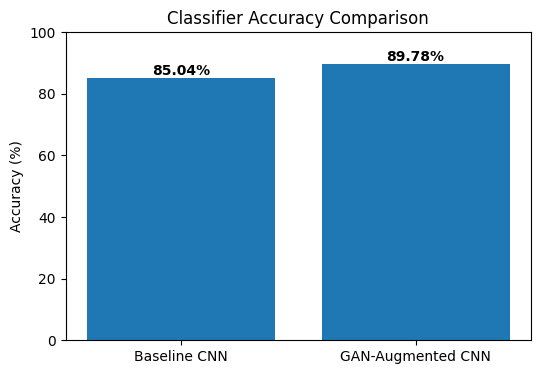

In [28]:
import matplotlib.pyplot as plt

# Accuracy values (update baseline if needed)
baseline_acc = 85.04
gan_aug_acc = 89.78

models = ['Baseline CNN', 'GAN-Augmented CNN']
accuracies = [baseline_acc, gan_aug_acc]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.title('Classifier Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
plt.show()


Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



📊 EfficientNet (Balanced & Augmented) Accuracy: 76.29%
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00         0
   dandelion       0.00      0.00      0.00         0
       roses       0.00      0.00      0.00         0
  sunflowers       0.00      0.00      0.00         0
      tulips       1.00      0.76      0.87       734

    accuracy                           0.76       734
   macro avg       0.20      0.15      0.17       734
weighted avg       1.00      0.76      0.87       734



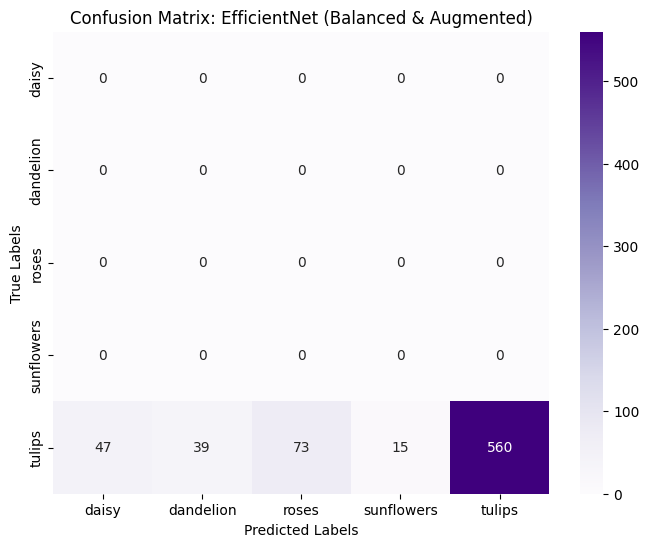

In [29]:
# 🌸 Day 5: Confusion Matrix and Classification Report Visualization

import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ✅ 1. Data setup
tf = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
data_dir = './FlowerGAN_Project/flowers'

# ✅ Load small test split (20% of real data)
full = datasets.ImageFolder(data_dir, transform=tf)
n = len(full)
test_start = int(0.8 * n)
test_ds = Subset(full, list(range(test_start, n)))
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
classes = full.classes
print("Classes:", classes)

from torchvision import models
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes = len(classes)

def build_model(n_classes):
    model = models.efficientnet_b0(pretrained=False)  # pretrained=False since we’ll load weights
    in_feats = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(in_feats, n_classes)
    )
    return model.to(device)

# ✅ 3. Evaluation function for EfficientNet models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(path, title):
    model = build_model(n_classes)
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = out.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(lbls.numpy())

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    print(f"\n📊 {title} Accuracy: {acc*100:.2f}%")

    print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# ✅ 4. Evaluate trained models
evaluate_model('./FlowerGAN_Project/effnet_b0_best.pth', 'EfficientNet (Balanced & Augmented)')


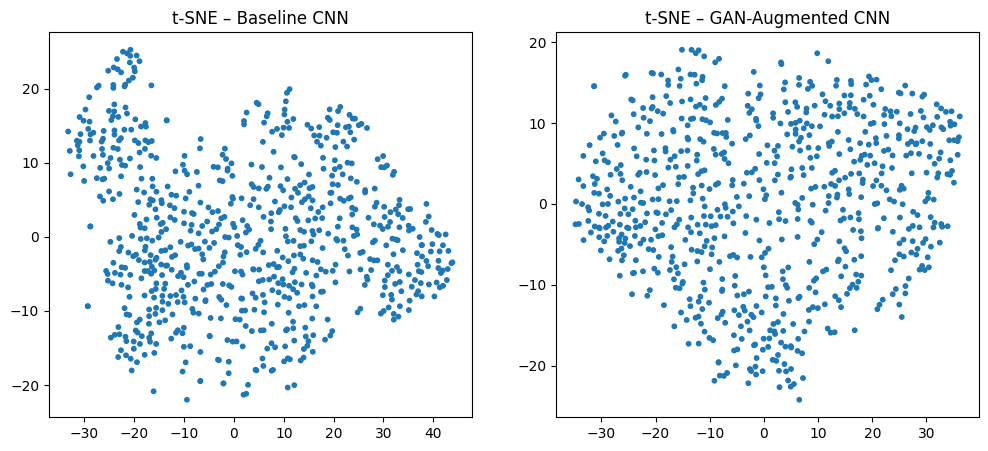

In [30]:
from sklearn.manifold import TSNE

def extract_features(model_path):
    m = CNNModel().to(device)
    m.load_state_dict(torch.load(model_path, map_location=device))
    m.eval()
    feats, labels = [], []
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            x = m.pool(m.relu(m.conv1(imgs)))
            x = m.pool(m.relu(m.conv2(x)))
            x = x.view(x.size(0), -1)
            x = m.relu(m.fc1(x))
            feats.append(x.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(feats), np.concatenate(labels)

feat_base, y_base = extract_features('./FlowerGAN_Project/model_baseline.pth')
feat_gan,  y_gan  = extract_features('./FlowerGAN_Project/model_augmented_final.pth')

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_base = tsne.fit_transform(feat_base[:2000])
emb_gan  = tsne.fit_transform(feat_gan[:2000])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(emb_base[:,0], emb_base[:,1], c=y_base[:2000], cmap='tab10', s=10)
plt.title("t-SNE – Baseline CNN")
plt.subplot(1,2,2)
plt.scatter(emb_gan[:,0], emb_gan[:,1], c=y_gan[:2000], cmap='tab10', s=10)
plt.title("t-SNE – GAN-Augmented CNN")
plt.show()